# Demonstration of SSM Functionality
This Jupyter Notebook gives an overview of the functionality of State Space Models (SSMs).

SSMs evolve from Control Theory and are defined by the state and output equations:
$$
\begin{aligned}
x'(t) &= Ax(t) + Bu(t) &&\text{(State Equation)}\\
y(t) &= Cx(t) + Du(t) &&\text{(Output Equation)}
\end{aligned}
$$

With:
$$
\begin{aligned}
u(t)&: \text{Input Signal}\\
x(t)&: \text{Latent State}\\
y(t)&: \text{Output Signal}\\
\end{aligned}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
from IPython.display import Image, Video, HTML
from utils.common import animate_spring_system
import torch

## 1) Discretization
To use the continuous SSM in a discrete context, we discretize the system. The different discretization techniques are explained in detail in the research article so we won't go into detail. We use the `Bilinear Transformation`, which gives us a discretized system:

$$
\begin{aligned}
x_k &= \bar{A}x_{k-1} + \bar{B}u_{k} &&\text{(State Equation)}\\
y_k &= Cx_k &&\text{(Output Equation)}
\end{aligned}
$$

Note that we replaced the time-dependent variables input $u(t)$, output $y(t)$ and state $x(t)$ in the equations with discrete variables $u_k$, $y_k$ and $x_k$.

The discretized matrices $\bar{A}$, $\bar{B}$ and $\bar{C}$ can be calculated from the continuous matrices $A$, $B$, $C$ as follows:

$$
\begin{aligned}
\bar{A} &= (I-\frac{\Delta}{2}A)^{-1}\cdot(I+\frac{\Delta}{2}A)\\
\bar{B} &= (I-\frac{\Delta}{2}A)^{-1}\cdot \Delta B\\
\bar{C} &= C
\end{aligned}
$$



In [2]:
def discretize(A: np.ndarray, B: np.ndarray, dt: float) -> tuple[np.ndarray, np.ndarray]:
    """
    Converts continuous-time matrices A, B into discrete-time versions using the bilinear transform.

    Parameters:
        A (ndarray): continuous-time state transition matrix
        B (ndarray): continuous-time input matrix
        dt (float): time step for discretization
    
    Returns:
        (A_d, B_d) (ndarray, ndarray): discrete-time state transition matrix A_d and discrete-time input matrix B_d
    """
    I = np.eye(A.shape[0])
    A_d = np.linalg.inv(I - 0.5 * A * dt) @ (I + 0.5 * A * dt)
    B_d = np.linalg.inv(I - 0.5 * A * dt) @ (B * dt)

    # Alternatively, using solve_triangular for better numerical stability and faster computation
    # A_d = la.solve_triangular(I - 0.5 * A * dt, I + 0.5 * A * dt, lower=True)
    # B_d = la.solve_triangular(I - 0.5 * A * dt, B * dt, lower=True)
    return A_d, B_d

## 2) Recurrent Calculation of the Output
Using the discretized system, we can recurrently calculate the state $x_k$ and output $y_k$, which is implemented in the `run_SSM()` function. Note that the calculations inside the for-loop are identical to the discretized system.

In [3]:
def run_SSM(A: np.ndarray, B: np.ndarray, C: np.ndarray, x0: np.ndarray, u: np.ndarray):
    """Runs the SSM recurrently over all inputs u"""

    # Convenience Variables
    seq_len = u.shape[0]
    state_size = x0.shape[0]

    # Ensure 1D arrays for x0, u, B, C
    x0 = x0.ravel()
    u = u.ravel()
    B = B.ravel()
    C = C.ravel()

    # Initialize input, state and output arrays
    y = np.zeros(seq_len + 1)
    x = np.zeros((seq_len + 1, state_size))
    x[0] = x0
    u = np.concatenate([[0], u])    # Prepend 0 to u, so the indexing matches with x and y
    
    # Iterate over the input
    for k in range(1, seq_len + 1):
        x[k] = A @ x[k-1] + B * u[k]
        y[k] = C @ x[k]
    return y[1:]    # Remove the prepended 0

## 3) Example: Spring System
The following code gives an example system of a mass attached to a wall with a spring.
We give it an input force $u$ and using the SSM, we can calculate the position of the mass $y$.

The derivation for the $A$, $B$ and $C$ matrices is given in the article, they are defined as:

$$
\begin{aligned}
A &= \begin{bmatrix}
0 & 1\\
-\frac{k}{m} & -\frac{b}{m}
\end{bmatrix}\\
B &= \begin{bmatrix}
0\\
\frac{1}{m}
\end{bmatrix}\\
C &= \begin{bmatrix}
1 & 0
\end{bmatrix}
\end{aligned}
$$

Where:
$$
\begin{aligned}
k&: \text{spring constant}\\
b&: \text{friction coefficient}\\
m&: \text{mass}
\end{aligned}
$$

### 3.1) Running the SSM

In [4]:
# Reference: https://srush.github.io/annotated-s4/

# Parameters
k = 40
b = 5
m = 1

# Initialize SSM Matrices
A = np.array([[0, 1], 
              [-k/m, -b/m]])
B = np.array([[0], 
              [1.0/m]])
C = np.array([[1.0, 0]])

# Generate an Input Signal
L = 200
step = 1.0 / L
ks = np.arange(L)
x = np.sin(10 * ks * step)
u = x * (x > 0.5)

# Discretize the SSM
A, B = discretize(A, B, step)

# Set the initial state
# x_0 = np.ones_like(B) * 0.001
x_0 = np.zeros_like(B)

# Run the SSM
y = run_SSM(A, B, C, x_0, u)

### 3.2) Animating the results

In [5]:
# Reference Code for animation: https://srush.github.io/annotated-s4/
anim = animate_spring_system(u, y)

# Save the animation
# anim.save("media/ssm.gif", dpi=150)
# Image("line.gif")
# anim.save("line.mp4", fps=25)
# Video("line.mp4")

# Show the animation
HTML(anim.to_html5_video())

## 4) Convolution

We can speed up the calculation of output $y$ by replacing the recurrent calculation of $y$ with a convolution, which makes it parallelizable.

$$
y = \bar{K} * u
$$

The derivation for the convolution kernel $K$ can be seen in the article, it looks as follows:

$$
\bar{K} = (\bar{C} \bar{B}, \bar{C} \bar{A}^1 \bar{B}, \dots, \bar{C} \bar{A}^k \bar{B})
$$

This can be easily implemented using numpy.

In [6]:
def calculate_K(A: np.ndarray, B: np.ndarray, C: np.ndarray, L: int) -> np.ndarray:
    """Calculate the convolution kernel K"""
    K = np.array([C @ np.linalg.matrix_power(A, i) @ B for i in range(L)])
    return K.squeeze()

### 4.1) Plotting the results
To compare recurrent and convolutional calculation, we plot both of them.

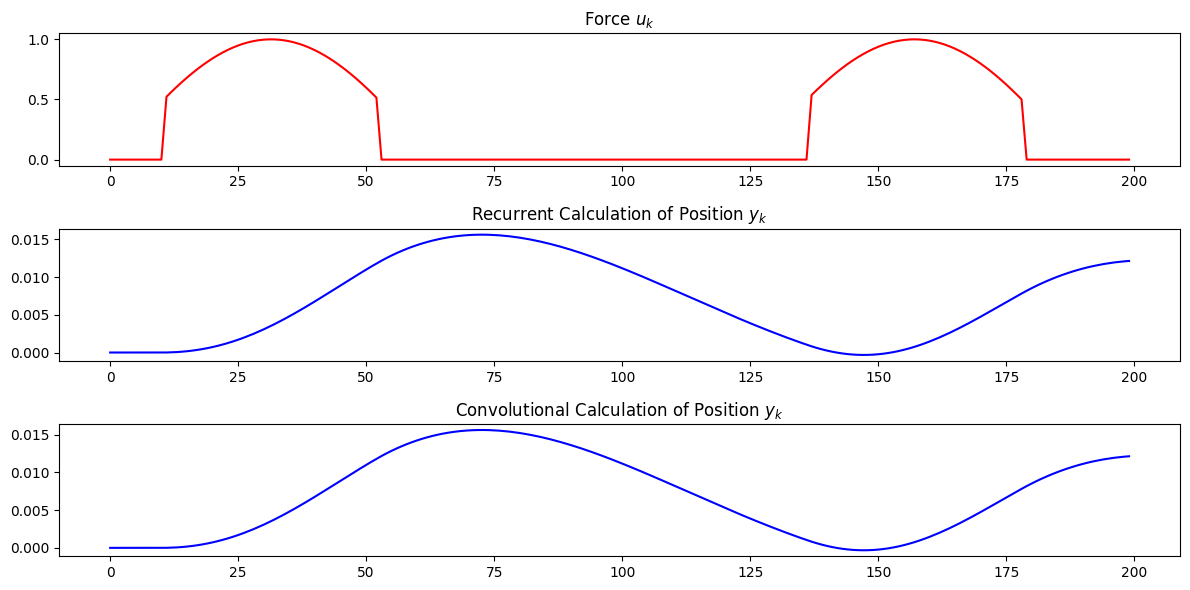

In [7]:
# Calculate the convolution kernel K
K = calculate_K(A, B, C, L)

# Calculate y using the convolution K * u
y_conv = np.convolve(K, u)[:L]

# Plot the results
fig, axs = plt.subplots(3, figsize=(12, 6))
axs[0].set_title("Force $u_k$")
axs[1].set_title("Recurrent Calculation of Position $y_k$")
axs[2].set_title("Convolutional Calculation of Position $y_k$")
axs[0].plot(u, color="red")
axs[1].plot(y, color="blue")
axs[2].plot(y_conv, color="blue")
plt.tight_layout()